## Intro
Notebook extracts feautures. Different cases are possible:
1. * absolute values of Page Impressions/Visits... or absolute values of visits and normalized values of PI etc. by visits  
   * rank-based (median, dif btw max & min), Gaussian-based (median, stdv) description of PI/V...
2. same as 1. + last behavior on website (difference compared to mean/median behaviour)
3. same as 2., but only subset of all features (no VDesktop, VMobile etc.)

### Preparation

In [4]:
import pandas as pd
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [21]:
## set flags for whole notebook
wLastUserBehavior = True
reducedFeatures = True

### Import Data

In [5]:
# user behavior
if wLastUserBehavior: 
    dat = pd.read_pickle('PIV_angereichert_metrics_wLastUserBehav')
else:
    dat = pd.read_pickle('PIV_angereichert_metrics')
dat.index.rename('idx', inplace=True)

In [7]:
# Newsletter
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
newsl_anmeld = pd.read_csv('../data/eCRM_SSOID_NL_Anmeldung.csv', sep=';', date_parser=dateparse, parse_dates=['Anmeldedatum'])
newsl_abmeld = pd.read_csv('../data/eCRM_SSOID_NL_Abmeldung.csv', sep=';', date_parser=dateparse, parse_dates=['Abmeldedatum'])
# An- und Abmeldedatum in einem
newsl = pd.merge(newsl_anmeld, newsl_abmeld, on=['SSO ID', 'Newsletter mit Klartext'])

In [8]:
#### neglect newsletter, where Anmeldedatum is after K Tag, since no influence on cancellation
## there is no occurence of this case
newsl = pd.merge(newsl, dat[['WT SSOID', 'K Tag']], how='left', left_on='SSO ID', right_on='WT SSOID')
print(sum((newsl['Anmeldedatum']-newsl['K Tag']).notna() & (newsl['Anmeldedatum']-newsl['K Tag'])<0))
newsl.drop(columns='K Tag', inplace=True)

0


### New Columns

#### Integrate newsletter data

In [9]:
nl_woDup = newsl.drop_duplicates(subset='SSO ID')
datnl=dat.merge(nl_woDup,how='left',left_on='WT SSOID', right_on='SSO ID')

# rename column and transorm column into 0s and 1s (has/does not have a newsletter)
datnl.rename(columns={'SSO ID':'Newsletter'}, inplace=True)

datnl.loc[datnl['Newsletter'].notna(),'Newsletter'] = 1
datnl.loc[datnl['Newsletter'].isna(),'Newsletter'] = 0

#### Vertragslaenge

In [10]:
datnl['Vertragslaenge'] = 0
datnl.loc[datnl['Kuendigungsstatus'] == 'gekuendigt', 'Vertragslaenge'] = round((datnl['K Tag']-datnl['VB Tag'])/np.timedelta64(1,'D'))
datnl.loc[datnl['Kuendigungsstatus'] == 'ungekuendigt', 'Vertragslaenge'] = round((datnl['VE Tag']-datnl['VB Tag'])/np.timedelta64(1,'D'))

#### Fill NaN

In [11]:
datnl.fillna(0,inplace=True)

## Make subgroups

##### Long vs. Short term-contracts

Split data set in long-term and short-term contracts (contractlength longer or shorter than 95 days)

In [17]:
datshort = datnl.loc[datnl['Vertragslaenge']<=95]
datlong = datnl.loc[datnl['Vertragslaenge']>95]

### Some insights

In [13]:
datshort.groupby(['Newsletter','Kuendigungsstatus']).size()

Newsletter  Kuendigungsstatus
0           gekuendigt           1299
            ungekuendigt         1020
1           gekuendigt             21
            ungekuendigt           19
dtype: int64

In [12]:
from scipy.stats import fisher_exact
fisher_exact([[1299,1020],[21,19]])
    

(1.1522408963585433, 0.7485121862200221)

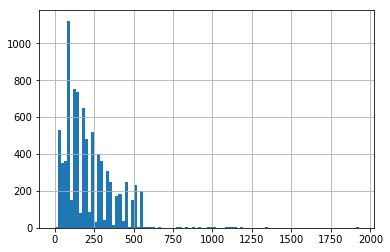

In [14]:
datnl.Vertragslaenge.hist(bins=100)

##### Exclude Sleepers

For longterm contracts the prediction is very bad. Maybe it helps to exclude 'Sleepers', i.e. people who have forgotten about their subscription and therefor no activity in the last 4 weeks.

Result: Recall becomes even worse when excluding sleepers. :(

In [15]:
dat_wosleepers = datnl.loc[-((datnl['v_2018/13'] + datnl['v_2018/14'] +
                           datnl['v_2018/15'] + datnl['v_2018/16']) == 0 )]

In [19]:
datshortwosleep = dat_wosleepers.loc[dat_wosleepers['Vertragslaenge']<=95]
datlongwosleep = dat_wosleepers.loc[dat_wosleepers['Vertragslaenge']>95]

print('short contracts with sleepers')
print(datshort.groupby('Kuendigungsstatus').size()/dat_wosleepers.shape[0])
print('')
print('long contracts with sleepers')
print(datlong.groupby('Kuendigungsstatus').size()/dat_wosleepers.shape[0])
print('\n\n')
print('short contracts without sleepers')
print(datshortwosleep.groupby('Kuendigungsstatus').size()/dat_wosleepers.shape[0])
print('')
print('long contracts without sleepers')
print(datlongwosleep.groupby('Kuendigungsstatus').size()/dat_wosleepers.shape[0])

short contracts with sleepers
Kuendigungsstatus
gekuendigt      0.268675
ungekuendigt    0.211480
dtype: float64

long contracts with sleepers
Kuendigungsstatus
gekuendigt      0.167922
ungekuendigt    1.088134
dtype: float64



short contracts without sleepers
Kuendigungsstatus
gekuendigt      0.033584
ungekuendigt    0.132709
dtype: float64

long contracts without sleepers
Kuendigungsstatus
gekuendigt      0.027071
ungekuendigt    0.806635
dtype: float64


### Which data to use?

##### Nutzerverhalten auf der Webseite 
Zeitreihen werden durch mean, mean normierter Standardabweichung, median, (max-min)/mean beschrieben.

 - visits (v)
 - page impressions (pi) absolut/per v
 - vPlus absolut/per v, Nutzer hat im Visit mind. einen Plus-Artikel angeguckt
 - piPlus
 - piSection absolut/per v, Nutzer hat auf Section geklickt
 - vSection absolut/per v
 - piArticle absolut/per v, Nutzer hat auf Article geklickt
 - piPlusArticle absolut/per v
 - vArticle absolut/per v
 - vPlusArticle absolut/per v
 - piComment absolut/per v, Nutzer hat einen Kommentar abgegeben
 - piPlusComment absolut/per v
 - vComment absolut/per v
 - vPlusComment absolut/per v
 - vMobile absolut/per v, Visit geht von Mobile aus
 - vDesktop absolut/per v, Visit geht von Desktop aus
 - vPlusDesktop
 - vPlusMobile
 
 ##### Andere Kennzahlen
 - newsl = (j/n), hatte jemals einen Newsletter
 - Vertragslänge in Tagen = wenn gekündigt, dann ('K Tag' - 'VB Tag'), sonst ('VE Tag - VB Tag')

In [24]:
### make sub-selections for columns

cols = datnl.columns.tolist()
## Metric: Gaussian
# absolut counts
cols_abs_gauss = [x for x in cols if ('_mean' in x) or ('sd_normed' in x) or ('zsc_usr_behav' in x)]
cols_abs_gauss = [x for x in cols_abs_gauss if '_per_v' not in x]
# absolute counts per visit
cols_per_v_gauss = [x for x in cols if ('_per_v_mean' in x) or 
                                       ('_per_v_sd_normed' in x) or
                                       ('_per_v_prz_usr_behav' in x)]
cols_per_v_gauss.extend(('v_mean','v_sd_normed',
                         'v_zsc_usr_behav4','v_zsc_usr_behav3',
                         'v_zsc_usr_behav2','v_zsc_usr_behav1'))

## Metric: Rank-based
# absolut counts
cols_abs_median = [x for x in cols if ('_median' in x) or ('_diff_max_min_normed' in x) or ('prz_usr_behav' in x)]
cols_abs_median = [x for x in cols_abs_median if '_per_v' not in x]
# absolute counts per visit
cols_per_v_median = [x for x in cols if ('_per_v_median' in x) or 
                                        ('_per_v_diff_max_min_normed' in x) or
                                        ('_per_v_prz_usr_behav' in x)]
cols_per_v_median.extend(('v_median','v_diff_max_min_normed',
                         'v_prz_usr_behav4','v_prz_usr_behav3',
                         'v_prz_usr_behav2','v_prz_usr_behav1'))

## additional features
# counts of active weeks in different categories
cols_acti = [x for x in cols if 'act' in x]
cols_acti_rem = [x for x in cols_acti if 'per_v' in x]
cols_acti_rem.append('pi_activ_wks')
cols_activ = [x for x in cols_acti if x not in cols_acti_rem]

# Labels + other features: Newsletter, Vertragslaenge 
cols_others = ['Newsletter','Vertragslaenge','Kuendigungsstatus']

cols_add = cols_activ + cols_others

In [25]:
#cols_add.remove('Vertragslaenge')

### create combinations of column names
cols_abs_gauss_final = cols_abs_gauss + cols_add
cols_abs_median_final = cols_abs_median + cols_add
cols_abs_allMetric_final = cols_abs_median + (cols_abs_gauss + cols_add)

cols_per_v_gauss_final = cols_per_v_gauss + cols_add
cols_per_v_median_final = cols_per_v_median + cols_add
cols_per_v_allMetric_final = cols_per_v_median + cols_per_v_gauss + cols_add

cols_abs_per_v_gauss_final = cols_abs_gauss + cols_per_v_gauss + cols_add
cols_abs_per_v_median_final = cols_abs_median + cols_per_v_median + cols_add
cols_abs_per_v_allMetric_final = cols_abs_gauss + cols_abs_median + cols_per_v_median + cols_per_v_gauss + cols_add

### prepare slicing of data, storage in dict
list_col_dat = [cols_abs_gauss_final, cols_abs_median_final, cols_abs_allMetric_final,
                cols_per_v_gauss_final, cols_per_v_median_final, cols_per_v_allMetric_final,
                cols_abs_per_v_gauss_final, cols_abs_per_v_median_final, cols_abs_per_v_allMetric_final]

names_dat_slices = ['dat_abs_gauss_final', 'dat_abs_median_final', 'dat_abs_allMetric_final',
                'dat_per_v_gauss_final', 'dat_per_v_median_final', 'dat_per_v_allMetric_final',
                'dat_abs_per_v_gauss_final', 'dat_abs_per_v_median_final', 'dat_abs_per_v_allMetric_final'] 

all_slices= {}
### slicing
for idx, slic in enumerate(list_col_dat):
    all_slices[names_dat_slices[idx]] = datnl.loc[:,slic].copy()   
    
short_contract = {}
for idx, slic in enumerate(list_col_dat):
    short_contract[names_dat_slices[idx]] = datshort.loc[:,slic].copy() 
    
long_contract = {}
for idx, slic in enumerate(list_col_dat):
    long_contract[names_dat_slices[idx]] = datlong.loc[:,slic].copy()
    


In [ ]:
if reducedFeatures:

    ls_to_remove = ['Mobile', 'Desktop','vPlusArticle','vPlusComment']

    def clean_features(liste):
        lis = []
        for x in liste:
            flag = 0
            for y in ls_to_remove:
                if y in x:
                    flag = 1
                    break
            if (flag == 0):
                lis.append(x)
        return lis

    all_slices= {}
    ### slicing
    for idx, slic in enumerate(list_col_dat):
        slic = clean_features(slic)
        all_slices[names_dat_slices[idx]] = datnl.loc[:,slic].copy()   

    short_contract = {}
    for idx, slic in enumerate(list_col_dat):
        slic = clean_features(slic)
        short_contract[names_dat_slices[idx]] = datshort.loc[:,slic].copy() 

    long_contract = {}
    for idx, slic in enumerate(list_col_dat):
        slic = clean_features(slic)
        long_contract[names_dat_slices[idx]] = datlong.loc[:,slic].copy()

### Save data

In [ ]:
## save data
import pickle
if wLastUserBehavior:
    pickle.dump( (all_slices,long_contract,short_contract), open( "dat_to_train_wlastBehav.pkl", "wb" ) )
else: 
    pickle.dump( (all_slices,long_contract,short_contract), open( "dat_to_train_wlastBehav.pkl", "wb" ) )